In [130]:
import pyvista as pv
import numpy as np

from geogen import model as geo
from geogen import plot as geovis
from geogen import probability as rv
from geogen.probability import SedimentBuilder

# Set rendering mode for notebook, use 'client' for interactive rendering
pv.set_jupyter_backend("static")


def make_history():
    # All units are in meters
    basement_level = -1500
    bedrock = geo.Bedrock(-1500, 0)
    sb = SedimentBuilder(1, 2000, 7, 7)
    values, thicknesses = sb.get_layers()
    sediment1 = geo.Sedimentation(values, thicknesses, base=basement_level)

    # Add micro fold noise to the model
    def noise_fold_params():
        wave_generator = rv.FourierWaveGenerator(num_harmonics=5, smoothness=0.8)
        return {
            "strike": np.random.uniform(0, 360),
            "dip": np.random.uniform(0, 360),
            "rake": np.random.uniform(0, 360),
            "period": np.random.uniform(100, 800),
            "amplitude": np.random.uniform(5, 15),
            "periodic_func": wave_generator.generate(),
        }

    sediment_noise = [
        geo.Fold(**noise_fold_params()) for _ in range(np.random.randint(4, 7))
    ]

    # Add a larger fold to the model
    wave_generator = rv.FourierWaveGenerator(num_harmonics=3, smoothness=1.2)
    damped_fourier = wave_generator.generate()
    larger_fold = geo.Fold(
        strike=30,
        dip=70,
        rake=15,
        period=4000,
        amplitude=500,
        periodic_func=damped_fourier,
    )

    # Unconformity
    unconformity = geo.UnconformityBase(0)

    # Bounce back on the larger fold
    larger_fold_rev = geo.Fold(
        strike=30,
        dip=70,
        rake=15,
        period=4000,
        amplitude=-200,
        periodic_func=damped_fourier,
    )

    # Dikes
    start_value = sediment1.last_value() + 4
    widths = [20, 30, 50, 70, 90]

    dikes = []
    for i in range(5):
        value = start_value + 0
        dike = geo.DikePlane(
            35 + 2 * i,
            80 - 3 * i,
            widths[i],
            origin=(100, 200 - (i**1.2) * 300, 0),
            value=value,
        )
        dikes += [dike]

    large_fault = geo.Fault(strike=30, dip=70, rake=45, amplitude=300, origin=(0, 0, 0))
    tilt = geo.Tilt(strike=-40, dip=8, origin=(0, 0, 0))

    # Go to next sequence in values
    value = dikes[-1].value + 1
    sedimentation2 = geo.Sedimentation(
        list(range(value, value + 6)), [155, 145, 110, 155, 145, 110], base=-900
    )

    # Final Bend
    bend = geo.Fold(strike=30 + 90, dip=0, rake=15, period=8000, amplitude=-500)
    history = (
        [bedrock, sediment1]
        + sediment_noise
        + [larger_fold, unconformity, larger_fold_rev]
        + dikes
        + [large_fault, tilt, sedimentation2, bend]
    )
    return history


history = make_history()

In [131]:
from geogen import generation as gen

# Add some random geowords to the model
w1 = gen.FaultSequence()
w2 = gen.FourierFold()
words = [w1, w2]

rand_hist = gen.generate_history(words)



In [132]:
model = geo.GeoModel(bounds = (-1920,1920), resolution=128)
model.add_history(history)
model.add_history(rand_hist)
model.compute_model(normalize=True)

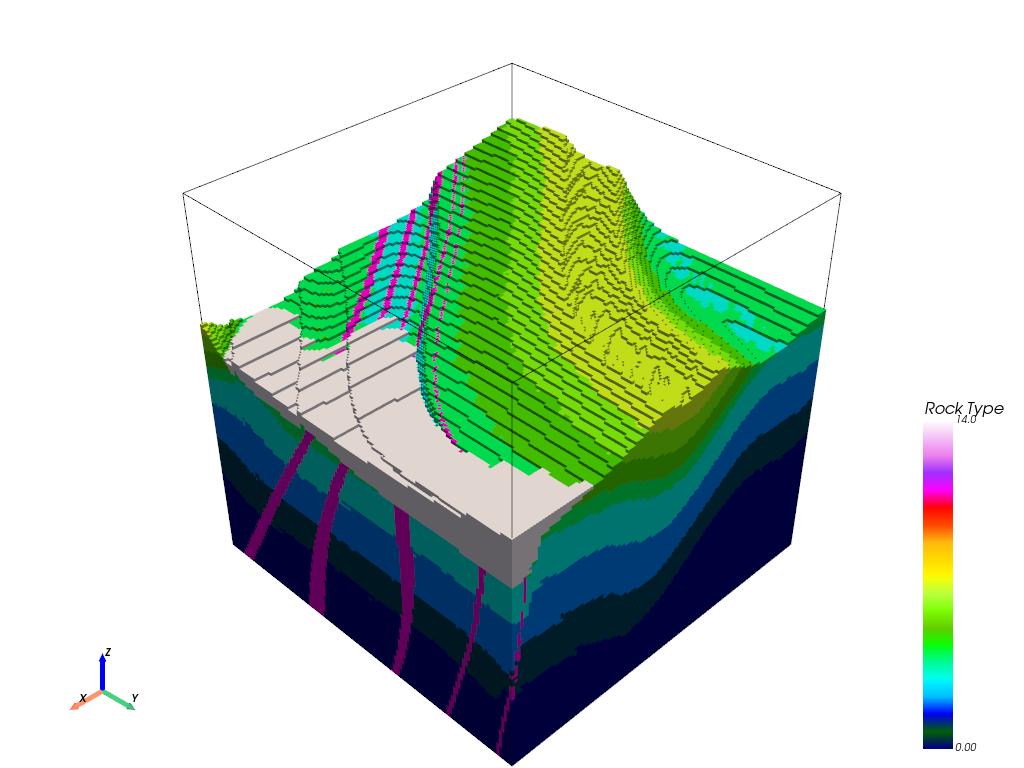

In [133]:
p = geovis.volview(model, clim=[0,14])
p.show()

In [134]:
from geogen.filemanagement import FileManager

# Save the desired model
fm = FileManager()
fm.save_geo_model(geo_model= model, save_dir= "./",lean=True)



Model saved to ./model_0.pkl


In [138]:
from geogen.filemanagement import FileManager

fm = FileManager(base_dir="./", auto_index=False)
models = fm.load_all_models()

Processing models in ./


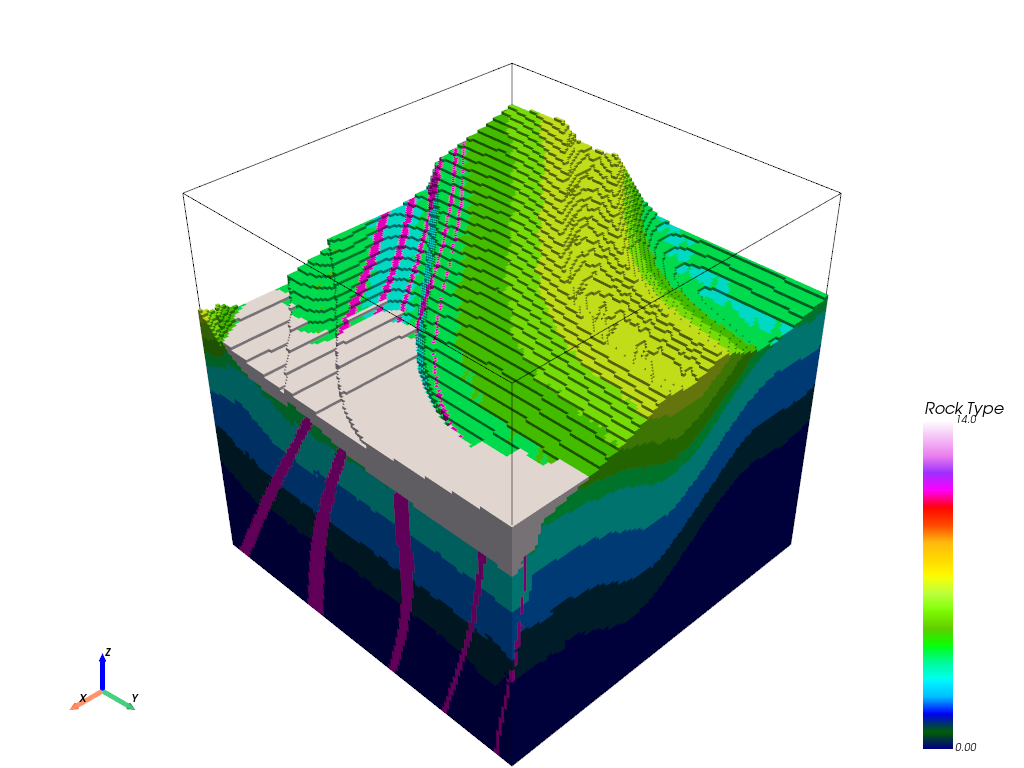

In [ ]:
models[0]
model.clear_data()
model.compute_model(normalize=True)
p.show()
